In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import lmfit
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import datetime
%matplotlib inline

# Predicting severe cases from deaths

In this script we will be predicting how many severe cases exist each day within a country from the cumulative number of deaths. 

We expect these numbers to be related, since deaths in theory all come from severe cases. We assume a constant death rate from severe cases over time. This entails that when deaths are on the rise, severe cases must be increasing as well. The time when severe cases are at their peak should be the time when deaths rise the most rapidly. When deaths start to flatten out, severe cases should be on the decline as well. 

This suggests a simple slope model for estimating severe cases. Since we are using cumulative deaths, the number will be monotonically increasing (or occassionally flat), meaning the slope over some number of days will never be negative. Similarly, the number of severe cases that exist per day cannot be negative. Following this train of thought, **we estimate the number of severe cases per day as the slope of cumulative deaths over some window of days, multiplied by a country-specific constant.** 

$$\#\ severe\ cases\ on\ day\ (i-lag\_days) = slope \Delta(deaths_{i-window\_size}...deaths_i)$$

Three are 3 parameters to this model:

1) window_size = how many days the sliding window should calculate the slope over

2) lag_days = the number of days earlier than the last date of the sliding window to assign predictions to (e.g. slope calculated over days 2-17 with 3 lag days is assigned to day 14 for prediction)

3) c = country-specific scaling constant for predictions

Note that severe cases here does not equal hospitalizations, since hospitalizations could include those who are not in the severe category and could fluctuate depending on bed capacity and admission policies by country/state/region. 

## France 

In [65]:
#Read data
france = pd.read_csv("Data/france_cases_deaths_severe_recovered_ministresante.csv", header = 0)
france["dateind"] = france.index 
france = france[["dateind", "date", "severe_ttl", "deaths_ttl"]]
france

,dateind,date,severe_ttl,deaths_ttl
0,0,2020-01-24,NaN,0
1,1,2020-01-25,NaN,0
2,2,2020-01-26,NaN,0
3,3,2020-01-27,NaN,0
4,4,2020-01-28,1.0,0
...,...,...,...,...
116,116,2020-05-19,1894.0,17714
117,117,2020-05-20,1794.0,17812
118,118,2020-05-21,1745.0,17870
119,119,2020-05-22,1701.0,17944


In [66]:
#Filter for deaths, dropping missing obs
france_deaths = france[["dateind", "deaths_ttl"]].dropna()

#Add severe case prediction category (= slope * c)
france_deaths["pred_severe"] = np.nan
france_deaths

,dateind,deaths_ttl,pred_severe
0,0,0,NaN
1,1,0,NaN
2,2,0,NaN
3,3,0,NaN
4,4,0,NaN
...,...,...,...
116,116,17714,NaN
117,117,17812,NaN
118,118,17870,NaN
119,119,17944,NaN


In [67]:
#Set params
window_size = 15
lag_days = 3
c = 15

In [68]:
#Calculate slopes over a rolling window
for i in range(window_size, france_deaths.shape[0]+1):
    X = france_deaths[i-window_size: i]["dateind"].to_numpy().reshape(-1, 1)
    Y = france_deaths[i-window_size: i]["deaths_ttl"].to_numpy().reshape(-1, 1)
    regressor = LinearRegression()  
    regressor.fit(X, Y)
    france_deaths.at[i-lag_days,"pred_severe"] = regressor.coef_[0] * c

In [70]:
#Join back onto full data
france = pd.merge(france, france_deaths,  
                  how='left', 
                  left_on=["dateind", "deaths_ttl"], 
                  right_on = ["dateind", "deaths_ttl"])

In [71]:
france

,dateind,date,severe_ttl,deaths_ttl,pred_severe
0,0,2020-01-24,NaN,0,NaN
1,1,2020-01-25,NaN,0,NaN
2,2,2020-01-26,NaN,0,NaN
3,3,2020-01-27,NaN,0,NaN
4,4,2020-01-28,1.0,0,NaN
...,...,...,...,...,...
116,116,2020-05-19,1894.0,17714,1648.285714
117,117,2020-05-20,1794.0,17812,1607.839286
118,118,2020-05-21,1745.0,17870,1547.625000
119,119,2020-05-22,1701.0,17944,NaN


In [83]:
#dates = france["date"]
#dates = [datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in dates]

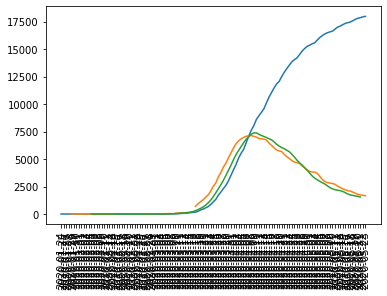

In [85]:
#Blue = cumulative deaths
#Orange = actual severe cases
#Green = predicted severe cases
plt.plot(france["date"], france["deaths_ttl"], france["severe_ttl"])
plt.plot(france["date"], france["pred_severe"])
plt.xticks(rotation=90)
plt.show()

# China

In [3]:
#Read data
china = pd.read_csv("Data/china_cases_severe_deaths_nhc.csv", header = 0)
china["dateind"] = china.index 
china = china[["dateind", "date", "severe_ttl", "deaths_ttl"]]
china

,dateind,date,severe_ttl,deaths_ttl
0,0,2020-01-21,NaN,0
1,1,2020-01-22,NaN,9
2,2,2020-01-23,95.0,17
3,3,2020-01-24,177.0,25
4,4,2020-01-25,237.0,41
...,...,...,...,...
122,122,2020-05-22,8.0,4634
123,123,2020-05-23,9.0,4634
124,124,2020-05-24,8.0,4634
125,125,2020-05-25,7.0,4634


In [4]:
#Filter for deaths, dropping missing obs
china_deaths = china[["dateind", "deaths_ttl"]].dropna()

#Add severe case prediction category (= slope * c)
china_deaths["pred_severe"] = np.nan
china_deaths

,dateind,deaths_ttl,pred_severe
0,0,0,NaN
1,1,9,NaN
2,2,17,NaN
3,3,25,NaN
4,4,41,NaN
...,...,...,...
122,122,4634,NaN
123,123,4634,NaN
124,124,4634,NaN
125,125,4634,NaN


In [5]:
#Set params
window_size = 15
lag_days = 3
c = 100

In [6]:
#Calculate slopes over a rolling window
for i in range(window_size, china_deaths.shape[0]+1):
    X = china_deaths[i-window_size: i]["dateind"].to_numpy().reshape(-1, 1)
    Y = china_deaths[i-window_size: i]["deaths_ttl"].to_numpy().reshape(-1, 1)
    regressor = LinearRegression()  
    regressor.fit(X, Y)
    china_deaths.at[i-lag_days,"pred_severe"] = regressor.coef_[0] * c

In [7]:
#Join back onto full data
china = pd.merge(china, china_deaths,  
                  how='left', 
                  left_on=["dateind", "deaths_ttl"], 
                  right_on = ["dateind", "deaths_ttl"])
china

,dateind,date,severe_ttl,deaths_ttl,pred_severe
0,0,2020-01-21,NaN,0,NaN
1,1,2020-01-22,NaN,9,NaN
2,2,2020-01-23,95.0,17,NaN
3,3,2020-01-24,177.0,25,NaN
4,4,2020-01-25,237.0,41,NaN
...,...,...,...,...,...
122,122,2020-05-22,8.0,4634,10.000000
123,123,2020-05-23,9.0,4634,9.642857
124,124,2020-05-24,8.0,4634,8.928571
125,125,2020-05-25,7.0,4634,NaN


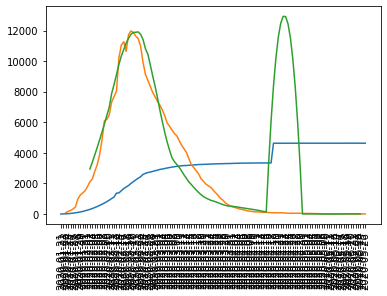

In [8]:
#Blue = cumulative deaths
#Orange = actual severe cases
#Green = predicted severe cases
plt.plot(china["date"], china["deaths_ttl"], china["severe_ttl"])
plt.plot(china["date"], china["pred_severe"])
plt.xticks(rotation=90)
plt.show()